# Creating a basic image classification model

### import required modules 

In [4]:
from PIL import Image
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import seaborn as sns


import pathlib


### Validate images

In [5]:
data_dir = './data'

for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.png'):
            try:
                img = Image.open(os.path.join(subdir, file))
                img.verify()
            except (IOError, SyntaxError) as e:
                print('Bad file:', os.path.join(subdir, file))

Select category for image classification and set the data dir to this category

In [90]:
category = 'Graphic-Style'

data_dir = pathlib.Path(f'./data/{category}/')

count number of images

In [91]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

11645


set variables

In [92]:
batch_size = 32
img_height = 256
img_width = 256

### Create data sets

In [93]:
# Load the full dataset and shuffle
full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

# Get the total number of images
total_images = full_dataset.cardinality().numpy() * batch_size

# Calculate the number of images for each split
test_split = 0.1
val_split = 0.2
test_size = int(total_images * test_split)
val_size = int(total_images * val_split)
train_size = total_images - test_size - val_size

# Split the full dataset into training, validation, and test sets
train_ds = full_dataset.take(train_size // batch_size)
val_test_ds = full_dataset.skip(train_size // batch_size)

val_ds = val_test_ds.take(val_size // batch_size)
test_ds = val_test_ds.skip(val_size // batch_size)


Found 11645 files belonging to 5 classes.


show classes

In [94]:
class_names = full_dataset.class_names
print(class_names)

['Cartoon', 'Fantasy', 'Low-Poly', 'Pixel-Art', 'Realistic']


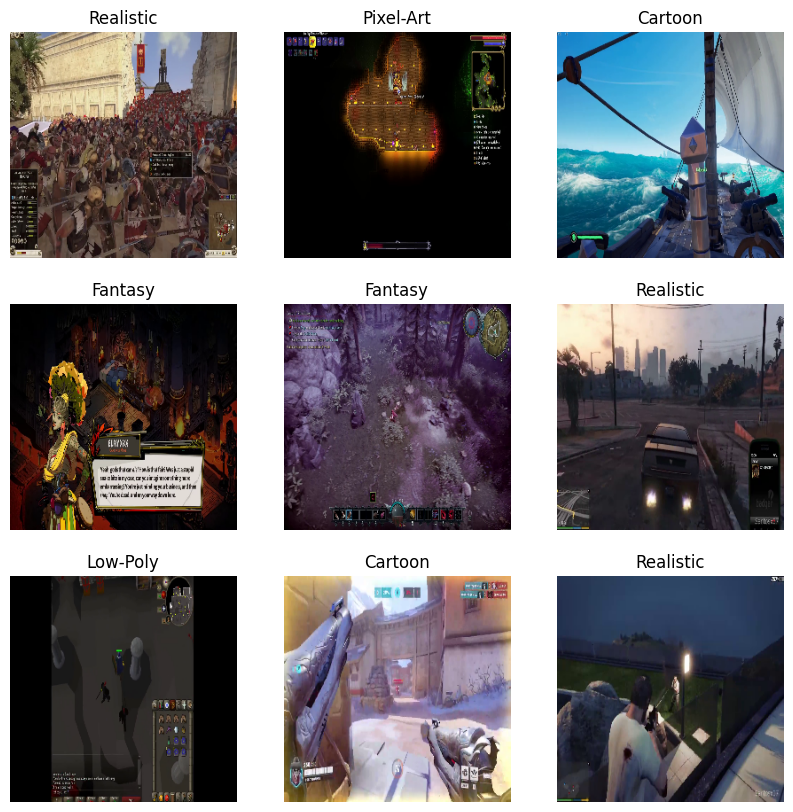

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [96]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [97]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

scale images to between 0 - 1

In [98]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


distort images to decrease overfitting

In [99]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\lukeg\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


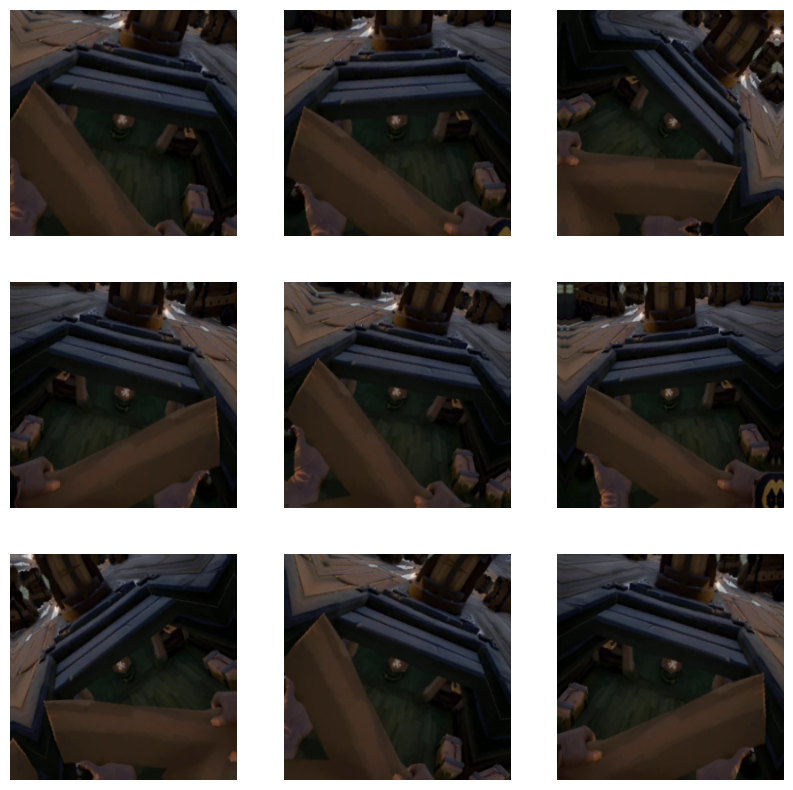

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model

Create a sequential model

In [14]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(num_classes, name="outputs")
])


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 25
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(f'./models/{category}-classifier-best-model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/25
254/254 ━━━━━━━━━━━━━━━━━━━━ 104s 406ms/step - accuracy: 0.5157 - loss: 1.9021 - val_accuracy: 0.7235 - val_loss: 1.1895 - learning_rate: 0.0010
Epoch 2/25
254/254 ━━━━━━━━━━━━━━━━━━━━ 86s 338ms/step - accuracy: 0.8083 - loss: 0.9463 - val_accuracy: 0.8424 - val_loss: 0.8502 - learning_rate: 0.0010
Epoch 3/25
254/254 ━━━━━━━━━━━━━━━━━━━━ 88s 345ms/step - accuracy: 0.8573 - loss: 0.7999 - val_accuracy: 0.8559 - val_loss: 0.7715 - learning_rate: 0.0010
Epoch 4/25
254/254 ━━━━━━━━━━━━━━━━━━━━ 83s 326ms/step - accuracy: 0.8685 - loss: 0.7480 - val_accuracy: 0.9045 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 5/25
254/254 ━━━━━━━━━━━━━━━━━━━━ 81s 321ms/step - accuracy: 0.8881 - loss: 0.6695 - val_accuracy: 0.8993 - val_loss: 0.6634 - learning_rate: 0.0010
Epoch 6/25
254/254 ━━━━━━━━━━━━━━━━━━━━ 83s 326ms/step - accuracy: 0.8982 - loss: 0.6380 - val_accuracy: 0.9119 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 7/25
254/254 ━━━━━━━━━━━━━━━━━━━━ 83s 328ms/step - accuracy: 0.

### Model accuracy summary

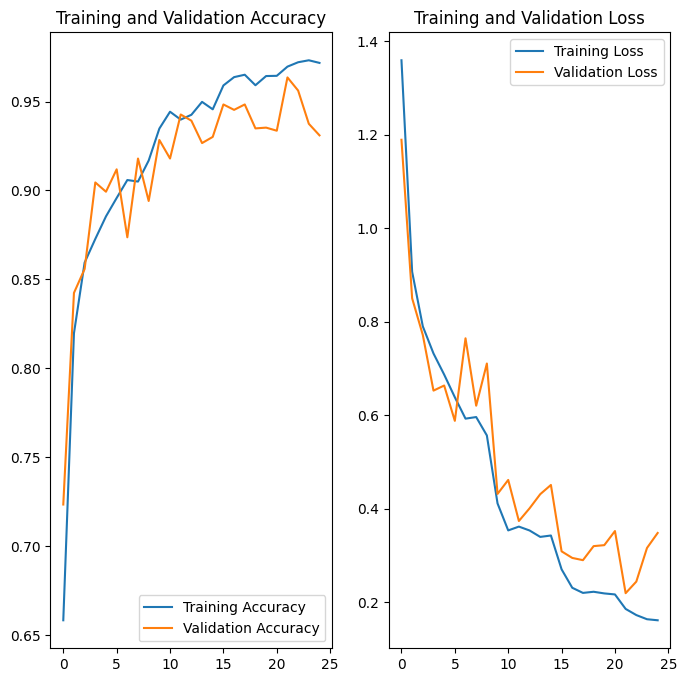

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Test model

Use an image path to evaluate the class of the image

In [30]:
test_path = pathlib.Path('.\examples\example1.png')

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
This image most likely belongs to Pixel-Art with a 99.92 percent confidence.


38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.9248 - loss: 0.3666
Test accuracy: 0.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8

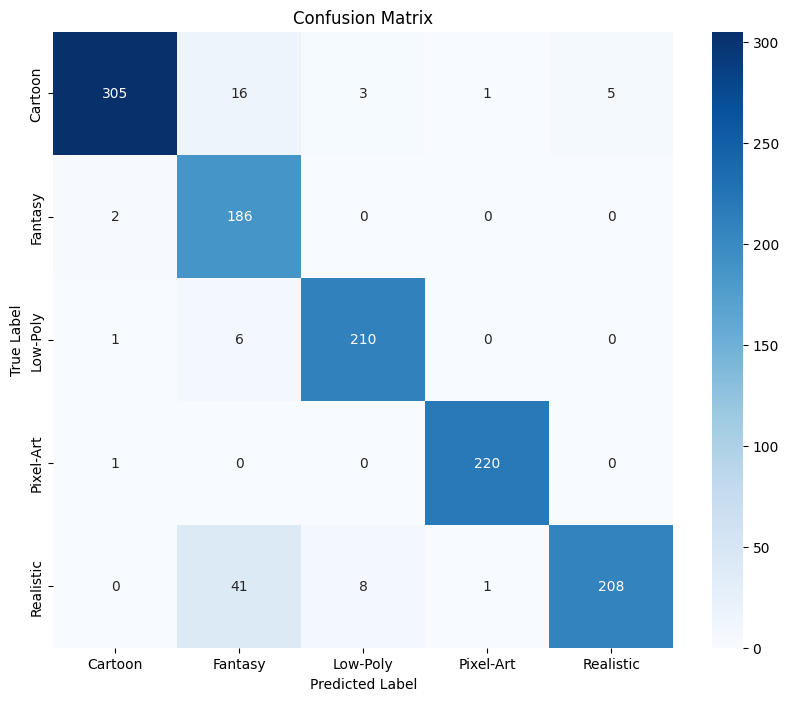

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.2f}')

# Predict the labels for the test set
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Convert lists to tensors
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.int64)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.int64)

# Calculate metrics using TensorFlow
accuracy = tf.metrics.Accuracy()(y_true_tensor, y_pred_tensor).numpy()
precision = tf.metrics.Precision()(y_true_tensor, y_pred_tensor).numpy()
recall = tf.metrics.Recall()(y_true_tensor, y_pred_tensor).numpy()
specificity = tf.metrics.SpecificityAtSensitivity(0.5)(y_true_tensor, y_pred_tensor).numpy()
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', confusion_mtx)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.class_names, yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


save the model using the category name

In [8]:
model.save(f'./models/{category}-classifier.keras')

NameError: name 'model' is not defined

load a previous model

In [3]:
model = tf.keras.models.load_model(f'./models/{category}-classifier-best-model.keras')

# Show the model architecture
model.summary()

NameError: name 'tf' is not defined

predict class using loaded model

In [116]:
test_path = pathlib.Path('./examples/e12.png')

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to Realistic with a 40.41 percent confidence.


45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.9464 - loss: 0.2235
Test accuracy: 0.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━

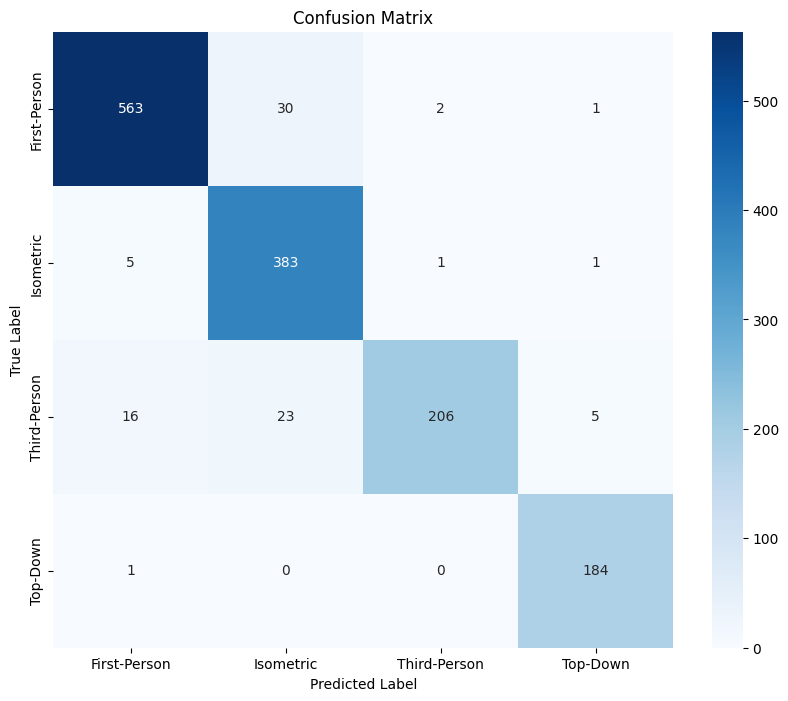

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model on test data
test_loss, test_acc = new_model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.2f}')

# Predict the labels for the test set
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = new_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Convert lists to tensors
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.int64)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.int64)

# Calculate metrics using TensorFlow
accuracy = tf.metrics.Accuracy()(y_true_tensor, y_pred_tensor).numpy()
precision = tf.metrics.Precision()(y_true_tensor, y_pred_tensor).numpy()
recall = tf.metrics.Recall()(y_true_tensor, y_pred_tensor).numpy()
specificity = tf.metrics.SpecificityAtSensitivity(0.5)(y_true_tensor, y_pred_tensor).numpy()
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', confusion_mtx)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.class_names, yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
